# ref: https://youtu.be/iuQ_f3W5Ttk
"""
Dataset from: Dataset from: https://susanqq.github.io/UTKFace/ 
Latent space is hard to interpret unless conditioned using many classes.​
But, the latent space can be exploited using generated images.​
Here is how...
x Generate 10s of images using random latent vectors.​
x Identify many images within each category of interest (e.g., smiling man, neutral man, etc. )​
x Average the latent vectors for each category to get a mean representation in the latent space (for that category).​
x Use these mean latent vectors to generate images with features of interest. ​
This part of the code is used to generate 128x128x3 images (of faces) using a trained
generator model. 
Alo, faces can be generated using two random latent vectors and interpolated in between.
Finally, the features in the new images can be 'engineered' by doing simple arithmetic
between vectors that are used to generate images. 
In summary, you can find the latent vectors for Smiling Man, neutral face man, 
and a baby with neutral face and then generate a smiling baby face by:
    Smiling Man + Neutral Man - Neutral baby = Smiling Baby
    
"""

In [57]:
from numpy import asarray
from numpy.random import randn
from tensorflow.keras.models import load_model
import tensorflow as tf
from matplotlib import pyplot as plt

import numpy as np

In [58]:
#####################################################################
#Let us start by generating images using random latent vectors.
#########################################################################
# Function to generate random latent points
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	x_input = randn(latent_dim * n_samples)
	z_input = x_input.reshape(n_samples, latent_dim) #Reshape to be provided as input to the generator.
	return z_input

# Function to create a plot of generated images
def plot_generated(examples, n):
	# plot images
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :])
	plt.show()
 
         
def scaleToPlot(sample):
    sample = (sample + 1) / 2.0
    sample = (sample * 255).astype(np.uint8)
    return sample

In [59]:
# load the saved model
model = load_model('save_model/gan_UTKface_epochs1100.h5')

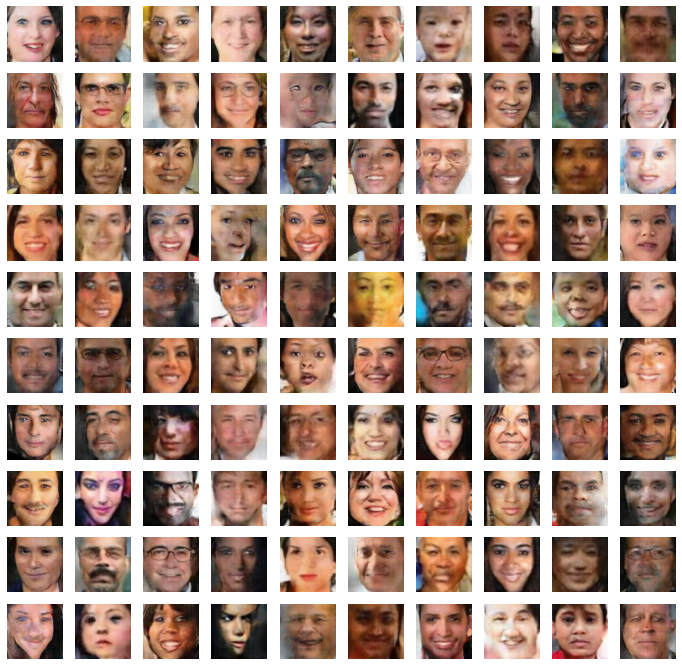

In [60]:
# generate latent vectors to be used as input to the generator
#Here, we are generating 25 latent vectors
latent_points = generate_latent_points(100, 100)
# generate images using the loaded generator model
X  = model.predict(latent_points)
# scale from [-1,1] to [0,1] for plotting
X = scaleToPlot(X)

# plot the generated images. Let us do 5x5 plot as we generated 25 images
plt.figure(figsize=(12, 12))
plot_generated(X, 10)

In [61]:
#####################################################################
#Now, let us generate 2 latent vectors and interpolate between them.
#Let us do linear interpolation although in reality the latent space is curved. 
#Interpolating between faces - Linear interpolation
#################################################################

from numpy import linspace

# Function to generate random latent points
#Same as defined above, re-defining for convenience. 
# def generate_latent_points(latent_dim, n_samples, n_classes=10):
#  	# generate points in the latent space
# 	x_input = randn(latent_dim * n_samples)
# 	z_input = x_input.reshape(n_samples, latent_dim) #Reshape to be provided as input to the generator.
# 	return z_input


In [62]:
# Interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=10):
 	# interpolate between points (e.g., between 0 and 1 if you divde to 10 then you have 0.111, 0.222, etc.)
	ratios = linspace(0, 1, num=n_steps)
 	# linear interpolation of vectors based on the above interpolation ratios
	vectors = list()
	for ratio in ratios:
		v = (1.0 - ratio) * p1 + ratio * p2
		vectors.append(v)
	return asarray(vectors)


# def plot_generated(examples, n):
#  	# plot images
# 	for i in range(n):
# 		plt.subplot(1, n, 1 + i)
# 		plt.axis('off')
# 		plt.imshow(examples[i, :, :])
# 	plt.show()

In [63]:
# load the model, if you haven't already loaded it above. 
# model = load_model('save_model/gan_UTKface200epochs.h5')

# generate points in latent space
#Let us generate 2 latent points between which we will interpolate
pts = generate_latent_points(100, 2)

# interpolate points in latent space
interpolated = interpolate_points(pts[0], pts[1]) # 0-9 steps
# generate images using the interpolated latent points
interpolated_predict = model.predict(interpolated)
# scale from [-1,1] to [0,1] for plotting
interpolated_predict = scaleToPlot(interpolated_predict)


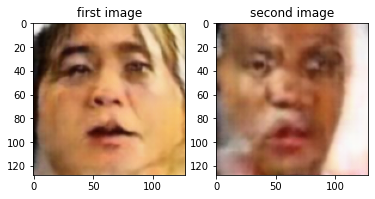

In [64]:
plt.subplot(1, 2, 1)
plt.title("first image")
plt.imshow(interpolated_predict[0, :, :])
plt.subplot(1, 2, 2)
plt.title("second image")
plt.imshow(interpolated_predict[9,: ,:])
plt.show()

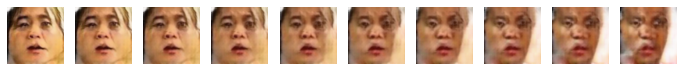

In [65]:
# plot the result
plt.figure(figsize=(12, 12))
for i in range(len(interpolated)):
    plt.subplot(1, len(interpolated), 1 + i)
    plt.axis('off')
    plt.imshow(interpolated_predict[i, :, :])
plt.show()

In [251]:
################################################################
#Now, let us perform arithmetic with latent points so we can generate faces
#with features of interest. 
#To work with latent points we must first generate a bunch of faces and 
#save them along with their corresponding latent points. This can be used
#to visually locate images of interest and thus identify the latent points.
#For example, latent points corresponding to baby face or sun glasses, etc. 
###########################################################

from numpy import mean, expand_dims
# example of loading the generator model and generating images

# Function to generate random latent points
#Same as defined above, re-defining for convenience. 
# def generate_latent_points(latent_dim, n_samples, n_classes=10):
#     x_input = randn(latent_dim * n_samples)
#     z_input = x_input.reshape(n_samples, latent_dim) #Reshape to be provided as input to the generator.
#     return z_input

# create a plot of generated images and save for easy visualization
def savePlot(examples, n, closePlot = False):
    plt.figure(figsize=(16, 16))
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(examples[i, :, :])
    plt.savefig('generated_faces.png')
    if closePlot:
        plt.close()
        
def plotFeature(data, result):
    n = len(data) + 1
    plt.figure(figsize=(12, 12))
    for i in range(n-1):
        plt.subplot(1, n, i+1)
        plt.title("feature{}".format(i+1))
        plt.imshow(data[i][0, :, :])
    
    plt.subplot(1, n, n)
    plt.title("new images")
    plt.imshow(result[0, :, :])
    plt.show()
    
def expandDims(data):
    for i in data:
        data[i] = expand_dims(data[i], 0)
    return data

def predictFeature(data, model):
    data = expand_dims(data, 0)
    data = model.predict(data)
    data = scaleToPlot(data)
    return data

In [67]:
# load the model, if you haven't already loaded it above
# model = load_model('save_model/gan_UTKface200epochs.h5')

# generate points in latent space that we can use to generate some images
#We then identify some images with our features of interest and locate thir corresponding latent vectors
latent_points = generate_latent_points(100, 100)
# print(latent_points.shape, "\n", latent_points[0], "\n", latent_points[0].shape)

c:\Users\Shatsuku\anaconda3\envs\gpu-gan\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

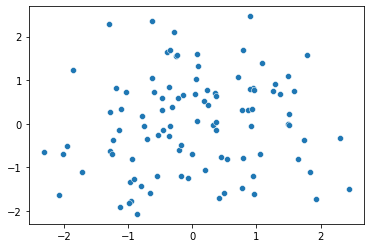

In [68]:
#Plot the latent points to see that they are spread around and we have no clue how to interpret them. 
import seaborn as sns
sns.scatterplot(latent_points[0], latent_points[1])


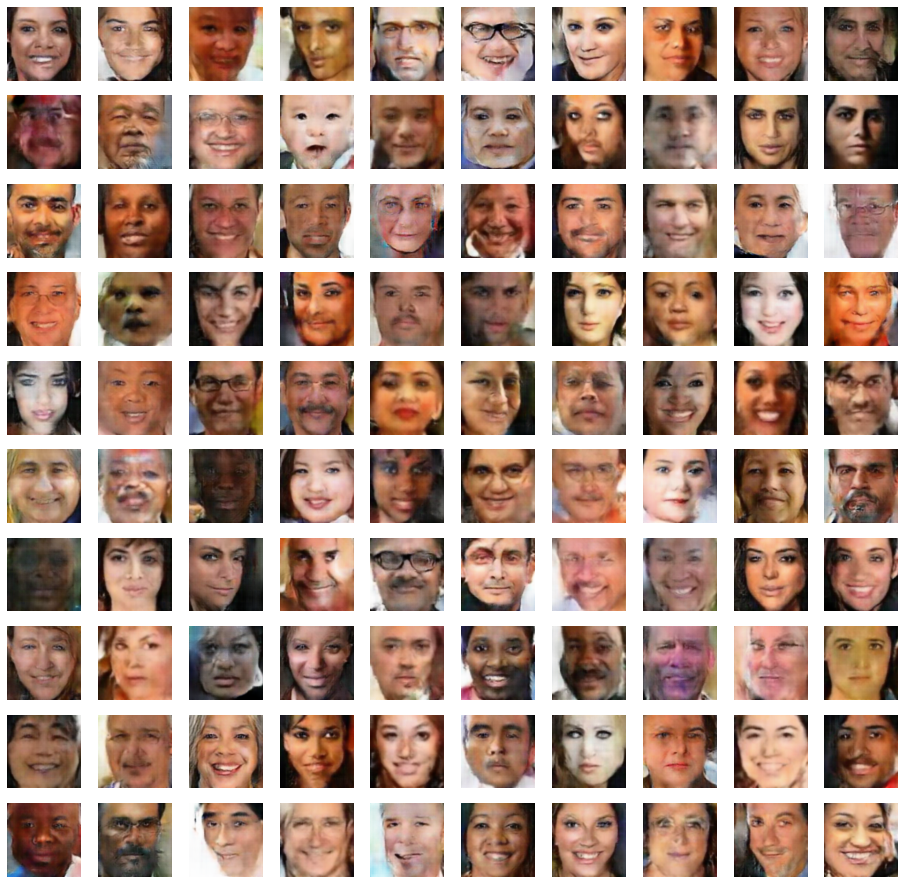

In [320]:
# generate images using the latent points. 
# latent_points have 100 samples
X  = model.predict(latent_points)

# scale from [-1,1] to [0,1] for plotting
X = scaleToPlot(X)

# plot and save generated 100 images
savePlot(X, 10)

In [70]:
# latent_points = generate_latent_points(100, 1)
# X  = model.predict(latent_points)
# # scale from [-1,1] to [0,1] for plotting
# X = (X + 1) / 2.0
# # plot and save generated images
# plt.imshow(X[0, :, :])

In [71]:
#Now, identify images corresponding to a specific type.
#e.g. all baby face images, smiling man images, 
# smiling man - neutral man + baby face = smiling baby

# retrieve specific points
#Now, identify images corresponding to a specific type.
#Start counting from 1 as we are going to offset our image number later, by subtracting 1.
#e.g. all baby face images, smiling man images, 
# smiling man - neutral man + baby face = smiling baby
#OR try adult with glasses  - adult no glasses + baby no glasses

#Identify a few images from classes of interest
# smiling_man_ix = [1, 10, 16, 26, 27, 28]
# neutral_man_ix = [16, 95, 63]
# baby_ix = [13,26,28,93,94]
# adult_with_glasses = [3,39,40]
# adult_no_glasses = [4, 7, 8]
#baby_no_glasses = [15,20]
# person_with_lipstick = [9, 10, 11, 31]
#person_no_lipstick = [1, 4, 9, 15]

In [72]:
#Reassign classes of interest to new variables... just to make it easy not
# to change names all the time we get interested in new features. 
# feature1_ix = adult_with_glasses
# feature2_ix = adult_no_glasses
# feature3_ix = person_with_lipstick

In [73]:
mySample = [16]

In [74]:
# Function to average list of latent space vectors to get the mean for a given type
def average_points(points, ix, isMean = True):
	# subtract 1 from image index so it matches the image from the array
    # we are doing this as our array starts at 0 but we started counting at 1. 
	zero_ix = [i-1 for i in ix]
	print(zero_ix)
	# retrieve required vectors corresponding to the selected images
	vectors = points[zero_ix]
	
	if isMean:
		# average the vectors
		vectors = mean(vectors, axis=0)
  
	return vectors

In [75]:
# average vectors for each class
# feature1 = average_points(latent_points, feature1_ix)
# feature2 = average_points(latent_points, feature2_ix)
# feature3 = average_points(latent_points, feature3_ix)
# print(feature1.shape)

In [76]:
# # Vector arithmetic....
# result_vector = feature1 - feature2 + feature3
# print(result_vector.shape)

In [77]:
inputSample = average_points(latent_points, mySample)

[15]


In [78]:
# oldImage = average_points(latent_points, mySample, isMean = False) # (100, 0) because not find mean

In [79]:
# # generate image using the new calculated vector
resultVector = expand_dims(inputSample, 0) # (100,) to (1, 100)
resultImage = model.predict(resultVector) # (1, 128, 128, 3)
# scale pixel values for plotting
resultImage = scaleToPlot(resultImage)

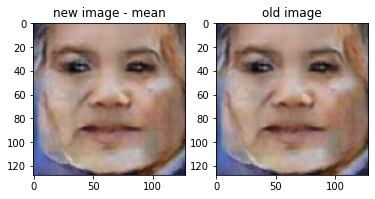

In [80]:
# input 1-sample from latent space to model and compare with old latent vector
# compare same images
plt.subplot(1, 2, 1)
plt.title("new image - mean")
plt.imshow(resultImage[0, :, :])
plt.subplot(1, 2, 2)
plt.title("old image")
plt.imshow(X[15,: ,:])
plt.show()

In [81]:
feature1 = latent_points[15]
feature2 = latent_points[61] # (100, )

result = feature1 + feature2

feature1 = expand_dims(feature1, 0)
feature2 = expand_dims(feature2, 0)
result = expand_dims(result, 0)

feature1 = model.predict(feature1)
feature2 = model.predict(feature2)
result = model.predict(result)

feature1 = scaleToPlot(feature1)
feature2 = scaleToPlot(feature2)
result = scaleToPlot(result)

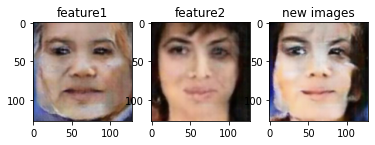

In [82]:
plt.subplot(1, 3, 1)
plt.title("feature1")
plt.imshow(feature1[0, :, :])
plt.subplot(1, 3, 2)
plt.title("feature2")
plt.imshow(feature2[0,: ,:])
plt.subplot(1, 3, 3)
plt.title("new images")
plt.imshow(result[0,: ,:])
plt.show()

In [190]:
# scale value on image

feature1 = latent_points[15] * 0.6
feature2 = latent_points[61] * 0.4

result = feature1 + feature2
# result = feature2 + feature1

feature1 = expand_dims(feature1, 0)
feature2 = expand_dims(feature2, 0)
result = expand_dims(result, 0)

feature1 = model.predict(feature1)
feature2 = model.predict(feature2)
result = model.predict(result)

feature1 = scaleToPlot(feature1)
feature2 = scaleToPlot(feature2)
result = scaleToPlot(result)

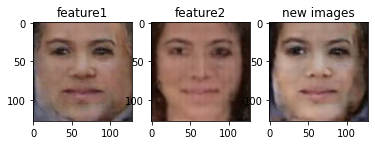

In [219]:
plotFeature(data=[feature1, feature2], result=result)

In [223]:
# multi scale
# scale value on image
feature1 = latent_points[5] * 0.7
sumFeature = average_points(latent_points, [53, 61, 91])
# feature2 = latent_points[52] * 0.5
# feature3 = latent_points[60] * 0.5
# feature4 = latent_points[90] * 0.5

result = feature1 + (sumFeature * 0.3)
# result = feature1 + ((feature2 + feature3 + feature4) * 0.3)
# result = feature2 + feature1

feature1 = expand_dims(feature1, 0)
result = expand_dims(result, 0)

feature1 = model.predict(feature1)
result = model.predict(result)

feature1 = scaleToPlot(feature1)
result = scaleToPlot(result)

[52, 60, 90]


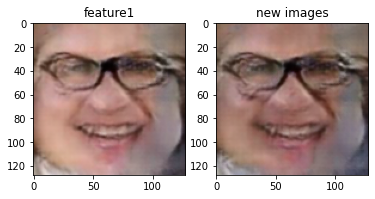

In [224]:
plotFeature([feature1], result)


In [246]:
# same as ablove
feature1 = latent_points[65] * 0.7
feature2 = latent_points[52] * 0.5
feature3 = latent_points[60] * 0.5
feature4 = latent_points[90] * 0.5

result = feature1 + ((feature2 + feature3 + feature4) * 0.3)


# feature1 = expand_dims(feature1, 0)
# feature2 = expand_dims(feature2, 0)
# feature3 = expand_dims(feature3, 0)
# feature4 = expand_dims(feature4, 0)
# result = expand_dims(result, 0)

feature1 = predictFeature(feature1, model=model)
feature2 = predictFeature(feature2, model=model)
feature3 = predictFeature(feature3, model=model)
feature4 = predictFeature(feature4, model=model)

result = predictFeature(result, model)

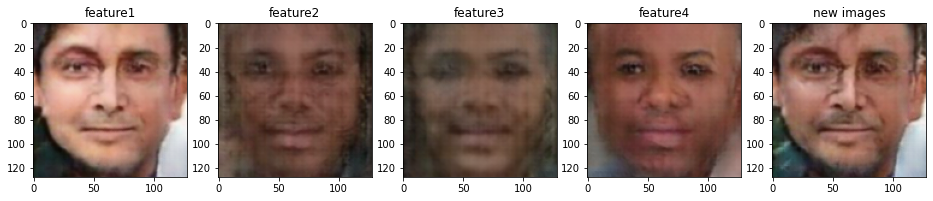

In [247]:
plotFeature([feature1, feature2, feature3, feature4], result)

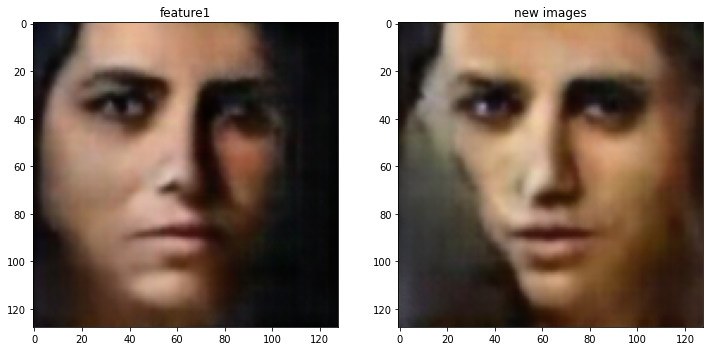

In [375]:
feature1 = latent_points[19] * 1

feature2 = latent_points[22] * 0.5
feature3 = latent_points[53] * 0.5
feature4 = latent_points[55] * 0.5

feature5 = latent_points[5] * 0.5
feature6 = latent_points[42] * 0.5
feature7 = latent_points[65] * 0.5

feature8 = latent_points[6] * 0.5
feature9 = latent_points[3] * 0.5
feature10 = latent_points[3] * 0.5


result = \
    (feature1 * 0.6) + \
    ((feature8 + feature9 + feature10) * 0.6)
    # ((feature2 + feature3 + feature4) * 0.2) + \
    # ((feature5 + feature6 + feature7) * 0.2) + \

feature1 = predictFeature(feature1, model)
result = predictFeature(result, model)
plotFeature([feature1], result)

End testing

In [56]:
from PIL import Image
import os
import cv2

In [57]:
SIZE = 128

In [58]:
img = cv2.imread("datasets/UTKFace/1_0_0_20161219192524675.jpg.chip" + ".jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #opencv reads images as BGR so let us convert back to RGB
img = Image.fromarray(img)
img = img.resize((SIZE, SIZE)) #Resize
img = np.array(img)

(128, 128, 3)


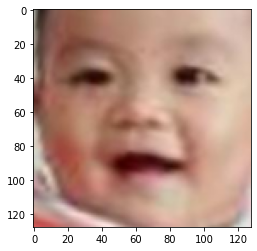

In [59]:
print(img.shape)
plt.imshow(img)

In [60]:
image_path = "datasets/UTKFace/" + "1_1_0_20170109190543118.jpg.chip" + ".jpg"

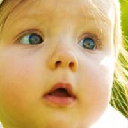

In [61]:
image = tf.keras.preprocessing.image.load_img(image_path, target_size=(SIZE, SIZE))
image

In [62]:
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
print(type(input_arr), input_arr.shape)

<class 'numpy.ndarray'> (1, 128, 128, 3)


In [63]:
input_arr = input_arr.astype('float32') / 255.  # This is VERY important
print(type(input_arr), input_arr.shape)

<class 'numpy.ndarray'> (1, 128, 128, 3)


In [64]:
# ค่าหายหมด
reshape_sample = np.resize(input_arr, (100,))
reshape_sample = np.reshape(reshape_sample, (-1,100))
reshape_sample.shape

(1, 100)

In [65]:
kidImage = model.predict(reshape_sample)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


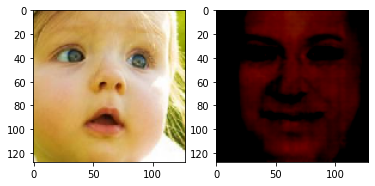

In [66]:
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.imshow(kidImage[0])